# Stock Screener
- Filter everything that has recent data (i.e. some other may be delisted)
- Filter according some criteria
- Plot

In [46]:
from matplotlib import pyplot as plt

from tradingdb.utils import *
from tradingdb.ORM.utils import *

from   datetime import datetime, timedelta

import copy

In [10]:
DBNAME=os.path.abspath("../data/master.db")

In [69]:
session=get_new_session(DBNAME)


In [12]:
# find last date
def get_last_price_for_period(stock):
    period=[]
    date=[]
    for p in stock.prices:
        date.append(p.date)
        period.append(p.period.name)
    periods=set(period)
    df=pd.DataFrame({'date':date,'period':period})
    return {pp:df[df['period'] == pp]['date'].max().to_pydatetime() for pp in periods}

stock_last_date={}
with session.begin() as mysession:
    q=mysession.query(stock.Stock)
    q=q.all()
    for r in q:
        stock_last_date[r.yf_symbol]=get_last_price_for_period(r)

In [27]:
# find last date for 1h

MYPERIOD='1h'
maxdate=datetime(1900, 7, 28, 0, 0)
for k,v in stock_last_date.items():
     if v[MYPERIOD]>maxdate: maxdate=v[MYPERIOD] 
print(maxdate)
# find all the symbols that have this as maxdate
yf_symbols=[]
for k,v in stock_last_date.items():
     if v[MYPERIOD]==maxdate: yf_symbols.append(k)
     

2023-07-28 16:00:00


In [28]:
print(yf_symbols)

['JD.L', 'CCH.L', 'FRES.L', 'SMT.L', 'NXT.L', 'RR.L', 'ADM.L', 'MRO.L', 'SN.L', 'III.L', 'BEZ.L', 'RKT.L', 'HLN.L', 'FCIT.L', 'CNA.L', 'PSH.L', 'INF.L', 'TSCO.L', 'WPP.L', 'SMDS.L', 'CRH.L', 'MNG.L', 'ABDN.L', 'IMB.L', 'BME.L', 'PSON.L', 'HL.L', 'ANTO.L', 'ULVR.L', 'GSK.L', 'DGE.L', 'IHG.L', 'BARC.L', 'AAL.L', 'PRU.L', 'HSBA.L', 'ENT.L', 'RIO.L', 'KGF.L', 'SBRY.L', 'ITRK.L', 'PHNX.L', 'UTG.L', 'BATS.L', 'BA.L', 'SGE.L', 'NG.L', 'CPG.L', 'BLND.L', 'SMIN.L', 'CTEC.L', 'SSE.L', 'AV.L', 'SKG.L', 'MNDI.L', 'EDV.L', 'SHEL.L', 'NWG.L', 'LAND.L', 'VOD.L', 'ABF.L', 'LSEG.L', 'GLEN.L', 'BRBY.L', 'FLTR.L', 'AZN.L', 'STAN.L', 'LGEN.L', 'BP.L', 'BNZL.L', 'REL.L', 'SGRO.L', 'SPX.L', 'WEIR.L', 'CRDA.L', 'STJ.L', 'WTB.L', 'FRAS.L', 'EXPN.L', 'UU.L', 'RS1.L', 'SVT.L', 'LLOY.L', 'BKG.L', 'IAG.L', 'AHT.L', 'AAF.L', 'RTO.L', 'DCC.L', 'TW.L', 'SDR.L', 'AUTO.L', 'HLMA.L', 'RMV.L', 'OCDO.L', 'PSN.L', 'BDEV.L', '^FTSE', '^FTAI']


In [44]:
## Now loop over the symbols and get the last N bars
dfinal={}
with session.begin() as mysession:
    for yf_symbol in yf_symbols:
        ohlcv={
            'date':[],
            'open':[],
            'close':[],
            'high':[],
            'low':[],
            'volume':[]
        }
        q=mysession.query(stock.Price)
        q=q.join(stock.Stock)
        q=q.join(stock.Period)
        q=q.filter(stock.Period.name==MYPERIOD)
        q=q.filter(stock.Stock.yf_symbol==yf_symbol)
        q=q.order_by(stock.Price.date.desc())
        q=q.limit(50)
        q=q.all()
        for r in q:
            for k in ohlcv.keys():
                ohlcv[k].append(getattr(r,k))
        dfinal[yf_symbol]=pd.DataFrame.from_dict(ohlcv)

        

MPLFinance Version : 0.12.9b7
0 0


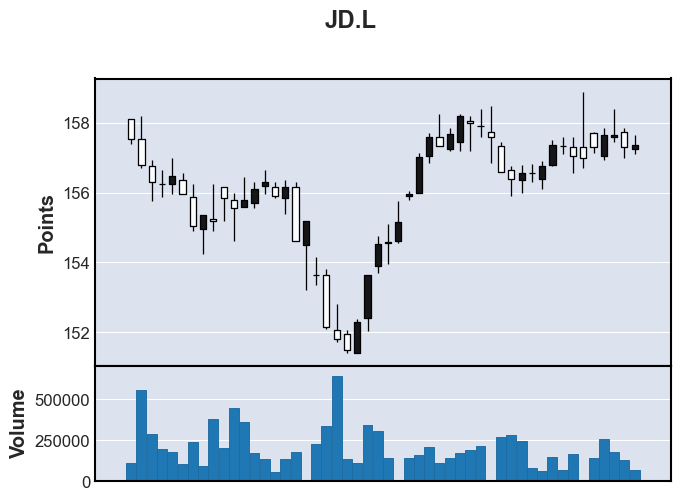

In [50]:
# now loop and plot

import mplfinance as fplt

print("MPLFinance Version : {}".format(fplt.__version__))

for k,v in dfinal.items():
    df=copy.deepcopy(v)
    df['Datetime'] = pd.to_datetime(df['date'])
    df = df.set_index('Datetime')
    #print(df.index.to_list()[0],df.index.to_list()[-1])

    ticks = pd.date_range(df.index.to_list()[0],df.index.to_list()[-1],freq='1H')

    #print(ticks)
    ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]
    ticklabels = [ tick.time().strftime('%H:%M') for tick in ticks ]
    print(len(ticklocations),len(ticklabels))
    #print(ticklabels)


    fig,ax =fplt.plot(
                df,
                type='candle',
                title=k,
                ylabel='Points',
                volume=True,
                returnfig=True
            )
    ax[0].xaxis.set_ticks(ticklocations)
    ax[0].set_xticklabels(ticklabels)

    # Display:
    fplt.show()

    
    break


In [77]:
import requests
import yfinance

import json

with open("../alphavantage.json", "r") as json_file:
    data = json_file.read()

# Step 3: Use 'json.loads()' to convert the JSON data into a Python dictionary
ALPHAVANTAGE_KEY = json.loads(data)["ALPHAVANTAGE_KEY"]

def get_latest_news(symbol,av_key):
    # Get the symbol information from Yahoo Finance
    stock_info = yf.Ticker(symbol)

    print(dir(stock_info))
    print(stock_info)
    # Get the symbol name from Yahoo Finance (full name, including company name)
    symbol_name = stock_info.info['longName']

    # API endpoint for Alpha Vantage's financial news
    endpoint = "https://www.alphavantage.co/query"
    api_key = av_key  # Get your API key from https://www.alphavantage.co/support/#api-key

    # Parameters for the API request
    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": "1min",  # Use any appropriate interval for intraday data
        "apikey": api_key
    }

    # Make the API request
    response = requests.get(endpoint, params=params)
    news_data = response.json()

    # Extract the latest news (if available) from the API response
    latest_news = news_data.get("News", {})

    return latest_news

JD.L  : the overall increase in the last 10 bars is above threshold
100 100


/var/folders/zp/kk47krpx4_97876w6039z3wh0000gn/T/ipykernel_35644/250752074.py:24: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]


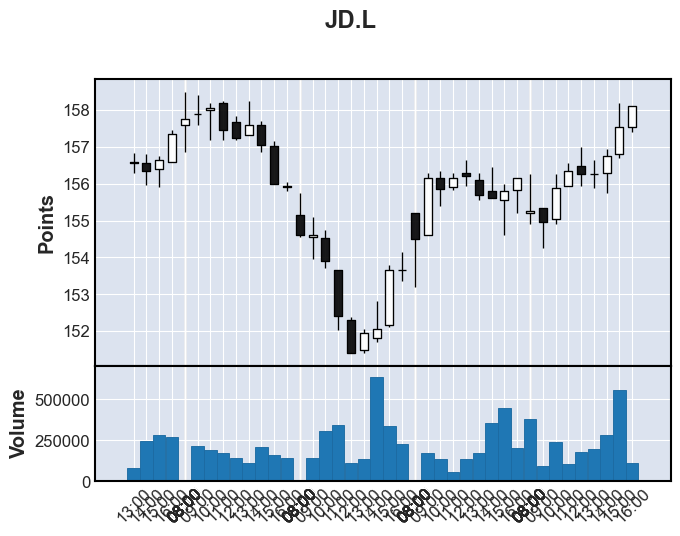

('JD Sports Fashion plc',)


TypeError: string indices must be integers

In [78]:
LAST_N=20
POSITIVE_N=10
CHANGET=0.02
for k,v in dfinal.items():
    df=copy.deepcopy(v)
    df['Datetime'] = pd.to_datetime(df['date'])
    df = df.set_index('Datetime')
    #print(df)
    df = df.sort_index(ascending=True)

    df['Close_Percentage_Change'] = df['close'].pct_change()

    last_N_bars_change = df['Close_Percentage_Change'].tail(LAST_N)
    overall_change = last_N_bars_change.sum()

    last_N_positive = df['Close_Percentage_Change'].tail(LAST_N).gt(0).sum()

    if overall_change >= CHANGET and last_N_positive >= POSITIVE_N:
        print(k," : the overall increase in the last 10 bars is above threshold")

        df=df[-LAST_N*2:]
        ticks = pd.date_range(df.index.to_list()[0],df.index.to_list()[-1],freq='1H')

        ticklocations = [ df.index.get_loc(tick,method='backfill') for tick in ticks ]
        ticklabels = [ tick.time().strftime('%H:%M') for tick in ticks ]
        print(len(ticklocations),len(ticklabels))
        #print(ticklabels)


        fig,ax =fplt.plot(
                    df,
                    type='candle',
                    title=k,
                    ylabel='Points',
                    volume=True,
                    returnfig=True
                )
        ax[0].xaxis.set_ticks(ticklocations)
        ax[0].set_xticklabels(ticklabels)

        fplt.show()

        with session.begin() as mysession:
            q=mysession.query(stock.Stock.company)
            q=q.filter(stock.Stock.yf_symbol==k)
            q=q.one()
            print(q)

        get_latest_news(k,ALPHAVANTAGE_KEY)
        break